In [9]:
!pip install openpyxl

In [1]:
import matplotlib.pyplot as plt

from preprocessing import trainTestClean
from preprocessing_dropna import trainTestCleanDropNa
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

import pandas as pd
import numpy as np

In [2]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
df_train, df_test = trainTestClean()
#df_train, df_test = trainTestCleanDropNa()

X_train = df_train.drop(columns=['price'])
y_train = df_train['price']
X_test = df_test.drop(columns=['price'])
y_test = df_test['price']

X_test = X_test[X_train.columns]

In [4]:
X_test.head()

,id,bedroomCount,bathroomCount,postCode,habitableSurface,hasAttic,hasBasement,buildingCondition,buildingConstructionYear,hasLift,floodZoneType,hasHeatPump,hasPhotovoltaicPanels,hasThermicPanels,landSurface,hasLivingRoom,livingRoomSurface,hasGarden,gardenSurface,parkingCountIndoor,parkingCountOutdoor,hasAirConditioning,hasArmoredDoor,hasVisiophone,hasOffice,toiletCount,hasSwimmingPool,hasFireplace,hasTerrace,terraceSurface,epcScore,facadeCount,isHouse,province_Antwerp,province_Brussels,province_East Flanders,province_Flemish Brabant,province_Hainaut,province_Limburg,province_Liège,province_Luxembourg,province_Namur,province_Walloon Brabant,province_West Flanders,heating_CARBON,heating_ELECTRIC,heating_FUELOIL,heating_GAS,heating_PELLET,heating_SOLAR,heating_WOOD,kitchen_HYPER_EQUIPPED,kitchen_INSTALLED,kitchen_NOT_INSTALLED,kitchen_SEMI_EQUIPPED,kitchen_USA_HYPER_EQUIPPED,kitchen_USA_INSTALLED,kitchen_USA_SEMI_EQUIPPED,kitchen_USA_UNINSTALLED,pricePerM2,subtype_APARTMENT,subtype_APARTMENT_BLOCK,subtype_BUNGALOW,subtype_CASTLE,subtype_CHALET,subtype_COUNTRY_COTTAGE,subtype_DUPLEX,subtype_EXCEPTIONAL_PROPERTY,subtype_FARMHOUSE,subtype_FLAT_STUDIO,subtype_GROUND_FLOOR,subtype_HOUSE,subtype_KOT,subtype_LOFT,subtype_MANOR_HOUSE,subtype_MANSION,subtype_MIXED_USE_BUILDING,subtype_OTHER_PROPERTY,subtype_PENTHOUSE,subtype_SERVICE_FLAT,subtype_TOWN_HOUSE,subtype_TRIPLEX,subtype_VILLA,terraceOrientation_0,terraceOrientation_EAST,terraceOrientation_NORTH,terraceOrientation_NORTH_EAST,terraceOrientation_NORTH_WEST,terraceOrientation_SOUTH,terraceOrientation_SOUTH_EAST,terraceOrientation_SOUTH_WEST,terraceOrientation_WEST,kde_price_per_m2_knn,has_kde_score
0,20543393,3,1,4317,168.0,1,1,-1,1974,0,0,0,0,0,683.0,1,23.0,1,500.0,0,0,0,0,0,0,1,0,0,1,1.0,330,3,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1428.571429,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.000426,1
1,20371063,5,2,4121,279.0,0,1,3,1994,0,0,0,1,0,3124.0,1,40.0,1,3124.0,1,0,0,0,0,0,2,0,0,1,30.0,250,4,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,2326.164875,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.000481,1
3,20537164,3,1,2140,172.0,0,1,3,1981,0,0,0,0,0,80.0,1,40.0,1,22.0,1,0,0,0,0,0,1,0,0,1,4.0,200,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,2296.511628,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.000543,1
5,20524364,3,2,1150,110.0,0,0,3,1974,0,0,0,0,0,444.0,0,0.0,0,0.0,0,0,0,0,0,0,1,0,0,1,7.0,95,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,4454.545455,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.000458,1
6,20583008,2,1,9940,73.0,0,0,-1,2005,0,0,0,0,0,444.0,1,0.0,0,0.0,0,0,0,0,1,0,1,0,0,0,0.0,200,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,2904.109589,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.000489,1


In [5]:
y_test.head()

0    240000.0
1    649000.0
3    395000.0
5    490000.0
6    212000.0
Name: price, dtype: float64

In [6]:
# Size of tensor :
head_size = X_train.drop(columns=['id']).shape[1]
head_size

93

In [7]:
model = nn.Sequential(
    nn.Linear(head_size, 512),
    nn.ReLU(inplace=True),
    nn.Linear(512, 1),
)
print(model)

Sequential(
  (0): Linear(in_features=93, out_features=512, bias=True)
  (1): ReLU(inplace=True)
  (2): Linear(in_features=512, out_features=1, bias=True)
)


In [8]:
model = nn.Sequential(
    nn.Linear(head_size, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(0.2),

    nn.Linear(512, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Dropout(0.2),

    nn.Linear(256, 1)
)

In [9]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

model.apply(init_weights)

Sequential(
  (0): Linear(in_features=93, out_features=512, bias=True)
  (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=512, out_features=256, bias=True)
  (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): Dropout(p=0.2, inplace=False)
  (8): Linear(in_features=256, out_features=1, bias=True)
)

In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss() 

x_scaler = StandardScaler()
X_train = x_scaler.fit_transform(X_train.drop(columns=['id']))
X_test = x_scaler.transform(X_test.drop(columns=['id']))

y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test = y_scaler.transform(y_test.values.reshape(-1, 1))


X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)



In [11]:
epochs = 200
batch_size = 64

dataset = TensorDataset(X_train_tensor, y_train_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

losses = []
for epoch in range(epochs):
    running_loss = 0.0
    model.train()
    for batch_X, batch_y in dataloader:

        batch_X = batch_X.clone().detach()
        batch_y = batch_y.clone().detach()

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(dataloader)
    losses.append(epoch_loss)

    if epoch % 10 == 0:
        print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item():.4f}')

Epoch [0/200], Loss: 1.0224
Epoch [10/200], Loss: 1.0908
Epoch [20/200], Loss: 0.2268
Epoch [30/200], Loss: 0.7843
Epoch [40/200], Loss: 0.1949
Epoch [50/200], Loss: 0.0862
Epoch [60/200], Loss: 0.3307
Epoch [70/200], Loss: 0.0407
Epoch [80/200], Loss: 0.6090
Epoch [90/200], Loss: 0.1232
Epoch [100/200], Loss: 0.1129
Epoch [110/200], Loss: 0.1393
Epoch [120/200], Loss: 0.0892
Epoch [130/200], Loss: 0.0664
Epoch [140/200], Loss: 0.1350
Epoch [150/200], Loss: 0.1130
Epoch [160/200], Loss: 0.0329
Epoch [170/200], Loss: 0.1036
Epoch [180/200], Loss: 0.1847
Epoch [190/200], Loss: 0.1909


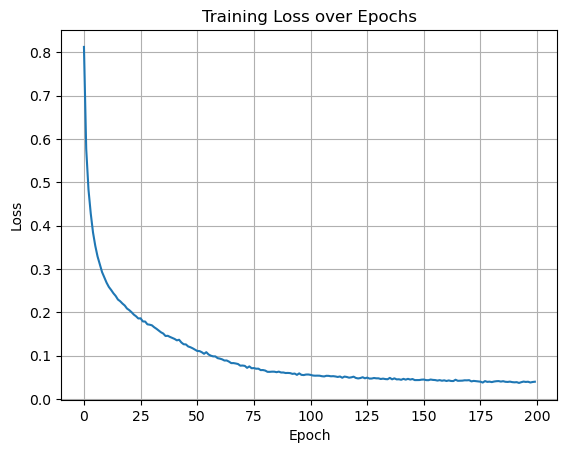

In [12]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.show()

In [13]:
model.eval()
with torch.no_grad():
    inputs = torch.tensor(X_test, dtype=torch.float32)
    targets = torch.tensor(y_test, dtype=torch.float32)

    predictions_scaled = model(inputs).squeeze()

    predictions = y_scaler.inverse_transform(predictions_scaled.reshape(-1, 1))
    predictions = torch.tensor(predictions, dtype=torch.float32).squeeze()

    targets = y_scaler.inverse_transform(y_test.reshape(-1, 1))
    targets = torch.tensor(targets, dtype=torch.float32).squeeze()
    
    mae_value = F.l1_loss(predictions, targets, reduction='mean')
    mse_value = F.mse_loss(predictions, targets, reduction='mean')

    errors = torch.abs(predictions - targets)
    mape = torch.mean(100 * errors / (targets + 1e-8))  # éviter la division par zéro
    #accuracy = 100 - torch.mean(mape)

    print(f"MAE = {mae_value.item():.4f}, MSE = {mse_value.item():.4f}, MAPE = {mape:.4f}%")

MAE = 21924.0469, MSE = 22351374336.0000, MAPE = 8.5770%
